In [344]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [345]:
import pixiedust
import pandas as pd
import numpy as np
import seaborn as sns
import os
from matplotlib import pyplot as plt
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from matplotlib.mlab import PCA as mlabPCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import statsmodels.formula.api as smf

# Suppress annoying harmless error.
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")
plt.rcParams['figure.figsize'] = (20.0, 10.0)

In [346]:
house = pd.read_csv("house_price.csv")

In [347]:
house.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

# The main feature: Sale Price

/Users/severinhatt/Virtualenvs/thinkful/base_plotting/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


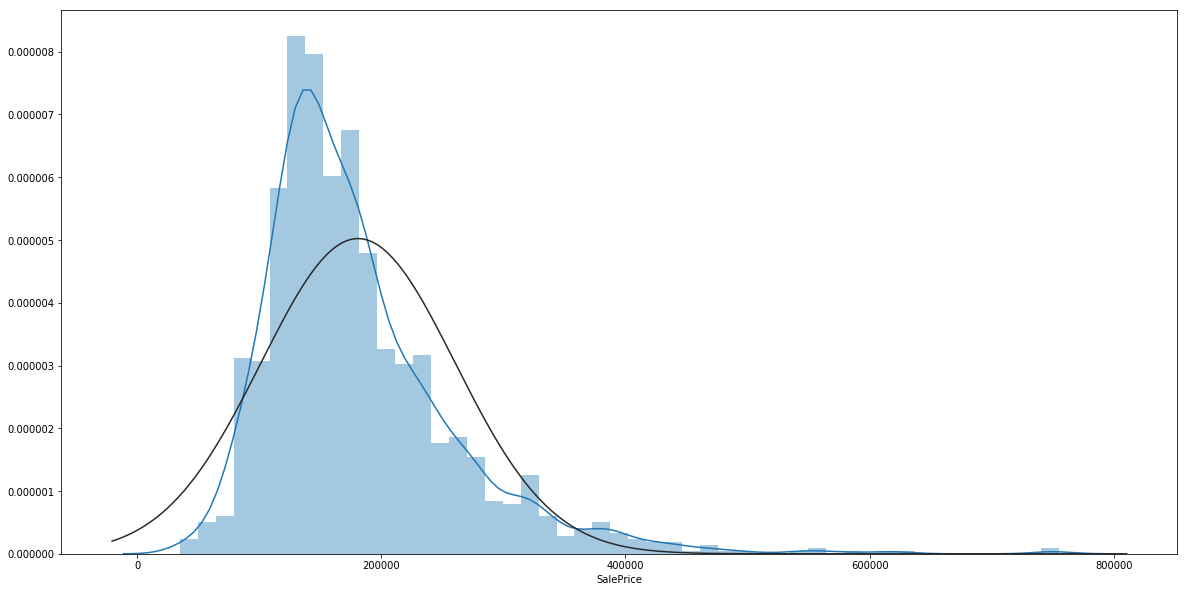

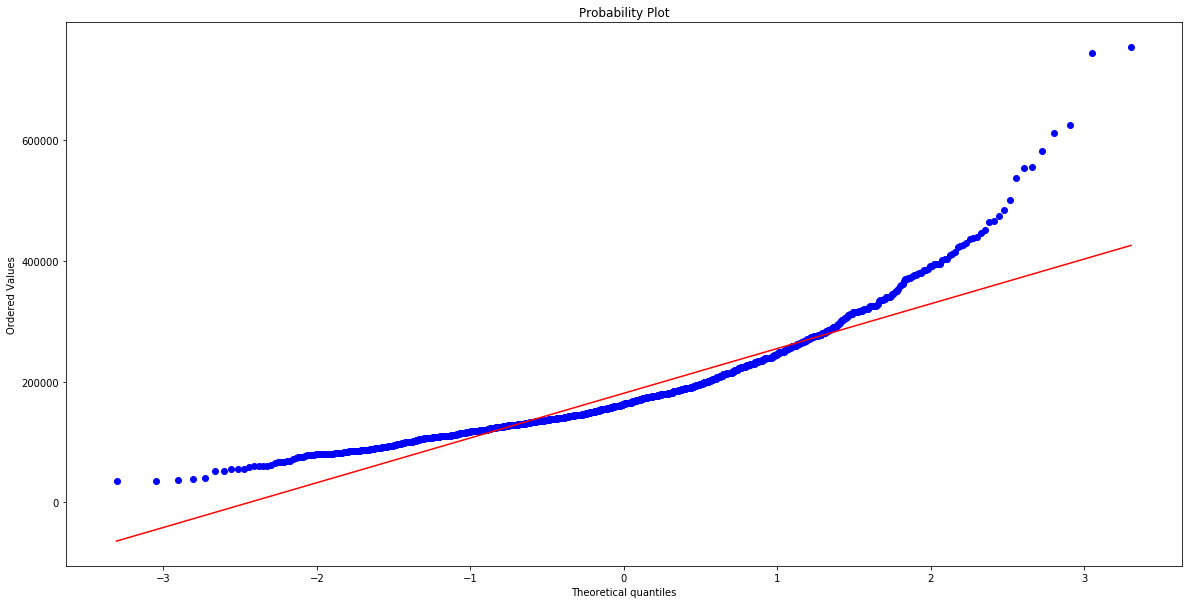

In [348]:
sns.distplot(house.SalePrice, fit=norm);
fig = plt.figure()
res = stats.probplot(house.SalePrice, plot=plt)

Doing a log tranformation helps getting the **SalePrice** to a normal distribution.

/Users/severinhatt/Virtualenvs/thinkful/base_plotting/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


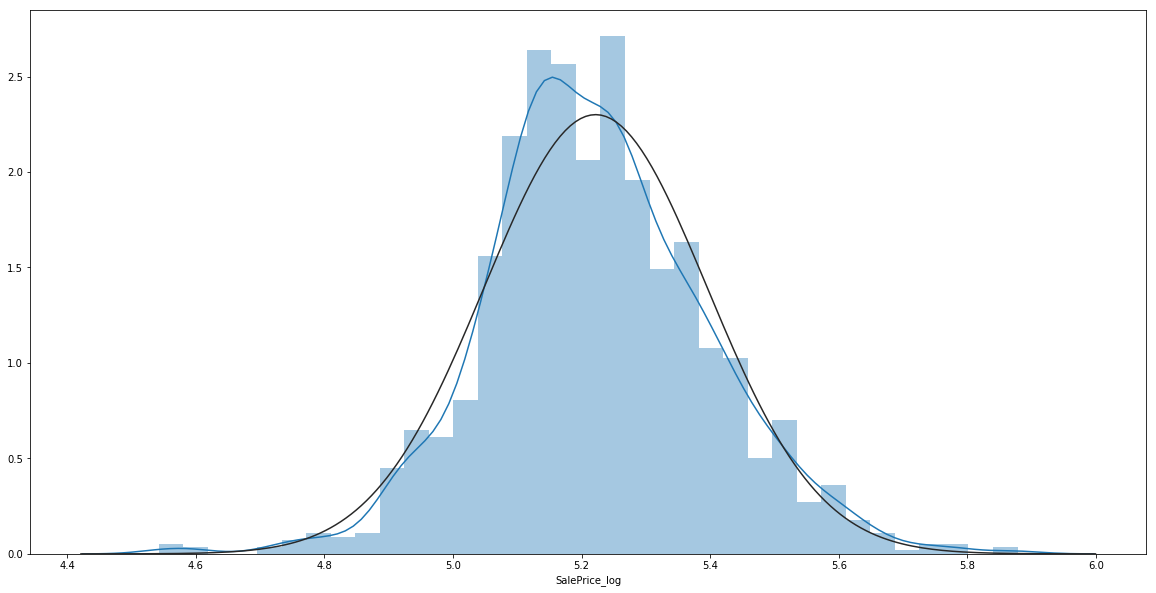

In [349]:
house["SalePrice_log"] = np.log10(house.SalePrice)
sns.distplot(house.SalePrice_log, fit=norm);

# House size: Which one


There are a couple of size to select from : which one will be the correct one ?
Some are a breakdown of previous variable.

We great a **_Total_SF** to have an overall size for the property, and we will test to see 

# Square space variables

In [350]:
house["_Total_SF"] = house.TotalBsmtSF + house.GrLivArea
square_space = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF','1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea',"_Total_SF"]
house[square_space].head(5)

,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,_Total_SF
0,706,0,150,856,856,854,0,1710,2566
1,978,0,284,1262,1262,0,0,1262,2524
2,486,0,434,920,920,866,0,1786,2706
3,216,0,540,756,961,756,0,1717,2473
4,655,0,490,1145,1145,1053,0,2198,3343


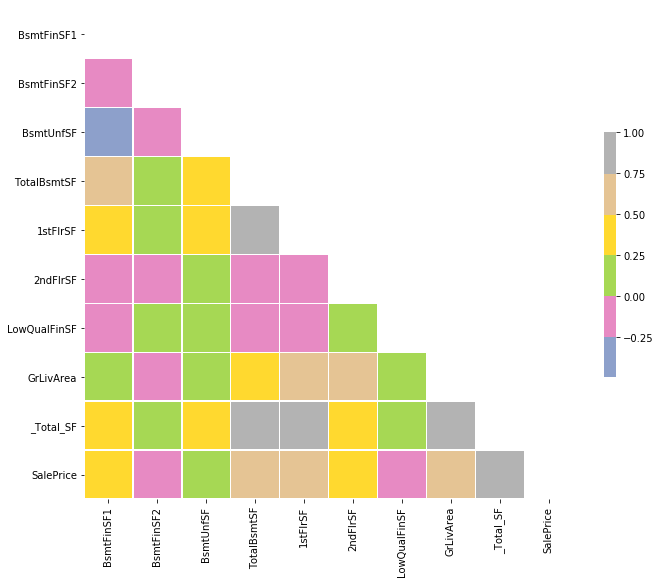

In [351]:
show_corr(house[square_space+["SalePrice"]])

# Pair grid with surface variable and Sale Price

From the pair grid, it seems that we have a better linearity between the Sale price with the Total square foot.

/Users/severinhatt/Virtualenvs/thinkful/base_plotting/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


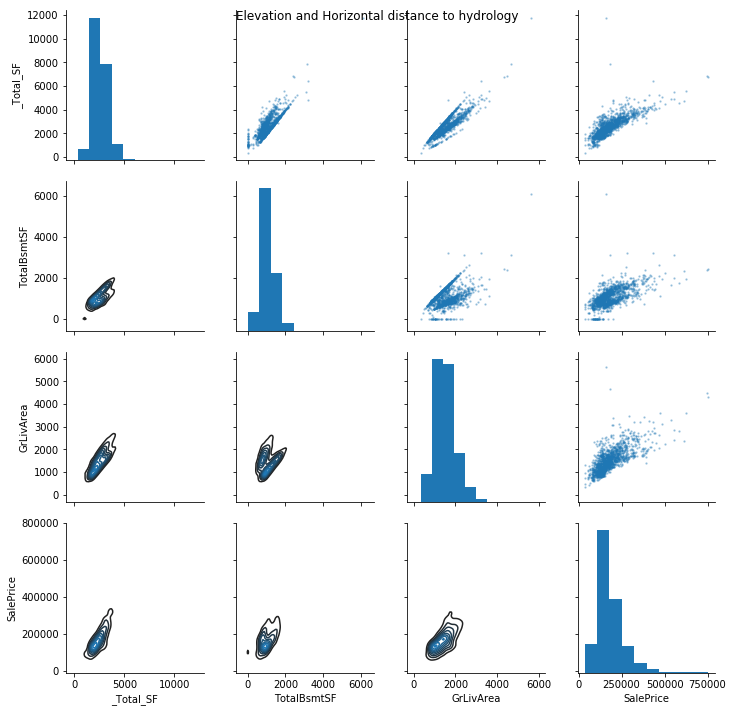

In [352]:
g = sns.PairGrid(house[["_Total_SF","TotalBsmtSF","GrLivArea","SalePrice"]],
                 diag_sharey=False)
g.fig.set_size_inches(10,10)
g.fig.suptitle("Elevation and Horizontal distance to hydrology")
g.map_lower(sns.kdeplot)
g.map_upper(plt.scatter,alpha=0.3, s=2)
g.map_diag(plt.hist)

In [353]:
house.Functional.value_counts()
#Home functionality (Assume typical unless deductions are warranted)

Typ     1360
Min2      34
Min1      31
Mod       15
Maj1      14
Maj2       5
Sev        1
Name: Functional, dtype: int64

Given potential impact on price and the very low numbers on the "Non-typical cases", we will ignore the non-typical cases for the moment.

Also, there seems to be some very large properties with strange pricing, that could be a significant impact on the regression, let's ignore then for the moment.

In [354]:
house = house[house.Functional=="Typ"][house._Total_SF < 6000].copy()

/Users/severinhatt/Virtualenvs/thinkful/base_plotting/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [355]:
house.shape

(1355, 83)

In [356]:
house["_Total_SF_log"] = np.log10(house._Total_SF)
house["GrLivArea_log"] = np.log10(house.GrLivArea)
y = house.SalePrice_log
X = house._Total_SF_log
X.head()

0   3.409
1   3.402
2   3.432
3   3.393
4   3.524
Name: _Total_SF_log, dtype: float64

In [357]:

linear_regression = smf.ols(formula='SalePrice_log ~ _Total_SF_log', data=house)
fitted_model = linear_regression.fit()
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          SalePrice_log   R-squared:                       0.688
Model:                            OLS   Adj. R-squared:                  0.688
Method:                 Least Squares   F-statistic:                     2986.
Date:                Fri, 23 Nov 2018   Prob (F-statistic):               0.00
Time:                        15:26:31   Log-Likelihood:                 1260.5
No. Observations:                1355   AIC:                            -2517.
Df Residuals:                    1353   BIC:                            -2507.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.5770      0.067     23.590      0.000       1.446       1.708
_Total_SF_log     1.0774      0.020     54.640      0.000       1.039       1.116
==============================================================================
Omnibus:                      173.178   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              349.441
Skew:                          -0.775   Prob(JB):                     1.32e-76
Kurtosis:                       4.946   Cond. No.                         94.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [358]:
linear_regression_2 = smf.ols(formula='SalePrice_log ~ GrLivArea_log', data=house)
fitted_model_2 = linear_regression_2.fit()
fitted_model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          SalePrice_log   R-squared:                       0.570
Model:                            OLS   Adj. R-squared:                  0.569
Method:                 Least Squares   F-statistic:                     1791.
Date:                Fri, 23 Nov 2018   Prob (F-statistic):          5.14e-250
Time:                        15:26:33   Log-Likelihood:                 1042.4
No. Observations:                1355   AIC:                            -2081.
Df Residuals:                    1353   BIC:                            -2070.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         2.3780      0.067     35.291      0.000       2.246       2.510
GrLivArea_log     0.9039      0.021     42.323      0.000       0.862       0.946
==============================================================================
Omnibus:                      100.123   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              170.632
Skew:                          -0.536   Prob(JB):                     8.87e-38
Kurtosis:                       4.369   Cond. No.                         76.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [359]:
regr = linear_model.LinearRegression()

for_reg = house[["SalePrice_log","_Total_SF_log","GrLivArea_log"]].fillna(0)
y = for_reg[["SalePrice_log"]]

for col in ["_Total_SF_log","GrLivArea_log"]:
    x = for_reg[[col]]
    print(col,cross_val_score(regr, x, y, cv=5))

_Total_SF_log [0.67847577 0.72067433 0.68297726 0.66643894 0.67754167]
GrLivArea_log [0.5736875  0.64405742 0.53960071 0.54573903 0.51609436]


In [360]:
def standardize(variable):
      return (variable - np.mean(variable)) / np.std(variable)

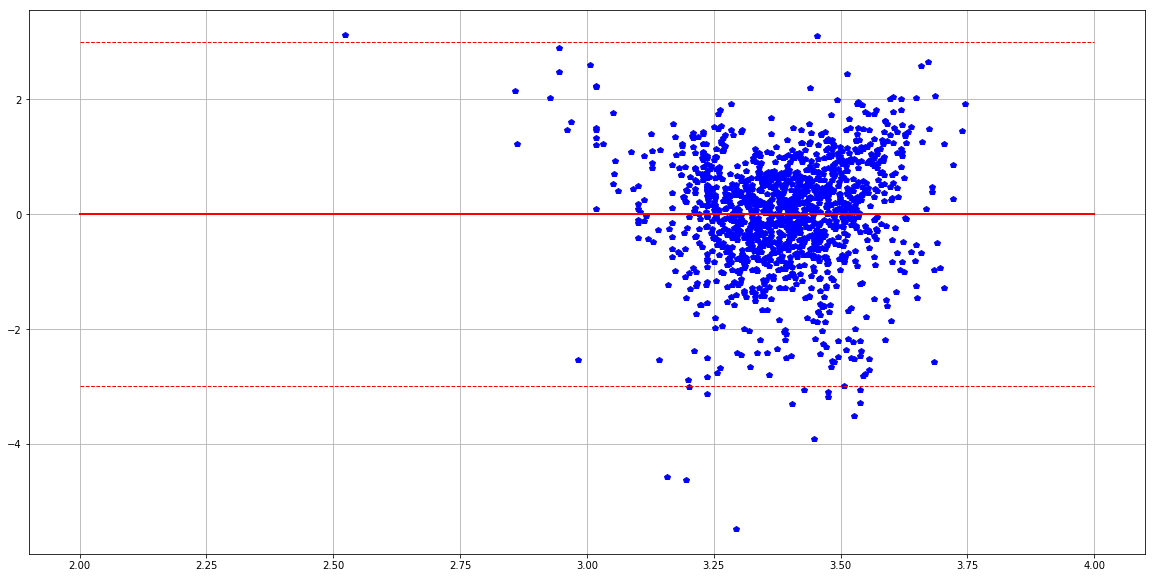

In [361]:
betas = np.array(fitted_model.params)
fitted_values = fitted_model.predict(X)
residuals = house.SalePrice_log-fitted_values
normalized_residuals = standardize(residuals)
residual_scatter_plot = plt.plot(house._Total_SF_log, normalized_residuals,'bp')
x_range = [house._Total_SF_log.min(),house._Total_SF_log.max()]
mean_residual = plt.plot([int(x_range[0]),round(x_range[1],0)], [0,0], '-', color='red', linewidth=2)
upper_bound = plt.plot([int(x_range[0]),round(x_range[1],0)], [3,3], '--', color='red', linewidth=1)
lower_bound = plt.plot([int(x_range[0]),round(x_range[1],0)], [-3,-3], '--', color='red', linewidth=1)
plt.grid()

In [404]:
other =['MSSubClass', 'MSZoning', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2',  'Heating',
       'HeatingQC', 'CentralAir', 'Electrical',
       'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageCars','GarageQual',
       'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC',
       'Fence', 'MiscFeature', 'MiscVal', 'SaleType',
       'SaleCondition','Total_Bath']

In [363]:
house["residual"] = residuals

In [364]:
columns_to_categorize = list(house.select_dtypes(include='object').columns)
for col in columns_to_categorize:
    house[col] = pd.Categorical(house[col])

# Per square feet price

Another way to interpret the current regression is that we are tryring to measure the price per square feet.

/Users/severinhatt/Virtualenvs/thinkful/base_plotting/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


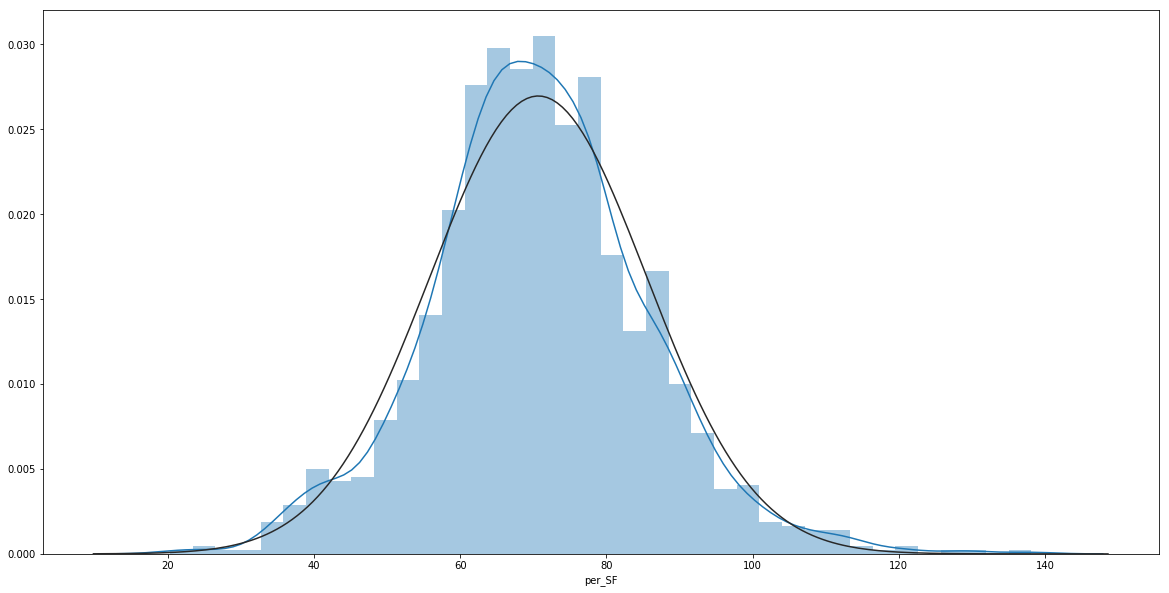

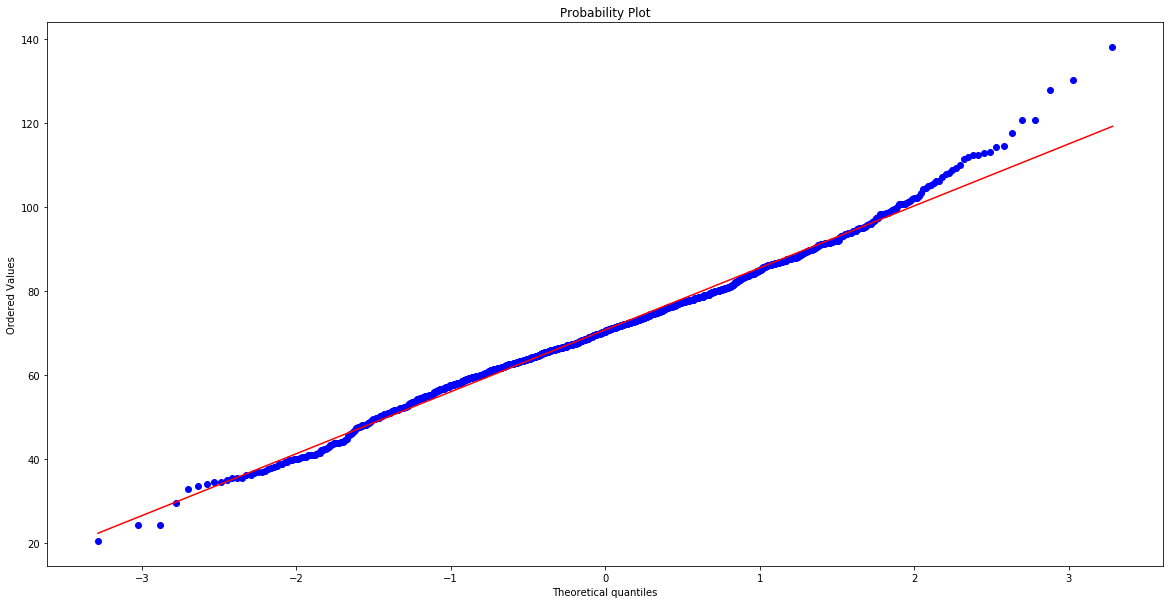

In [367]:
house["per_SF"] = house.SalePrice/house._Total_SF
sns.distplot(house.per_SF, fit=norm);
fig = plt.figure()
res = stats.probplot(house.per_SF, plot=plt)

In [368]:
house['SaleCondition'].cat.categories

Index(['Abnorml', 'AdjLand', 'Alloca', 'Family', 'Normal', 'Partial'], dtype='object')

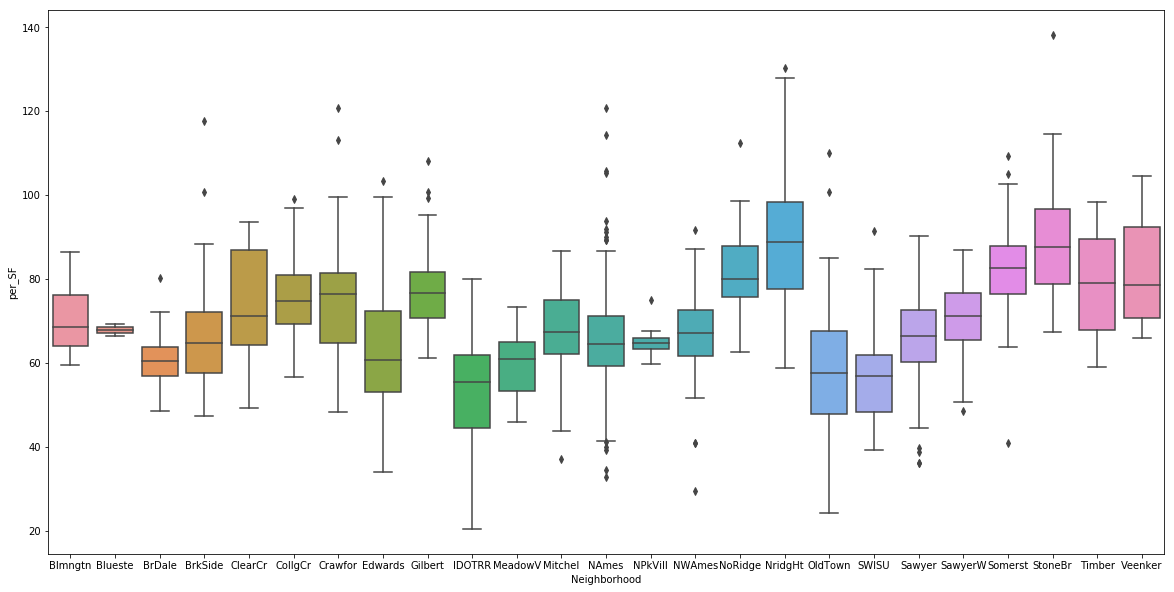

In [369]:
sns.boxplot(data=house,y="per_SF",x="Neighborhood")

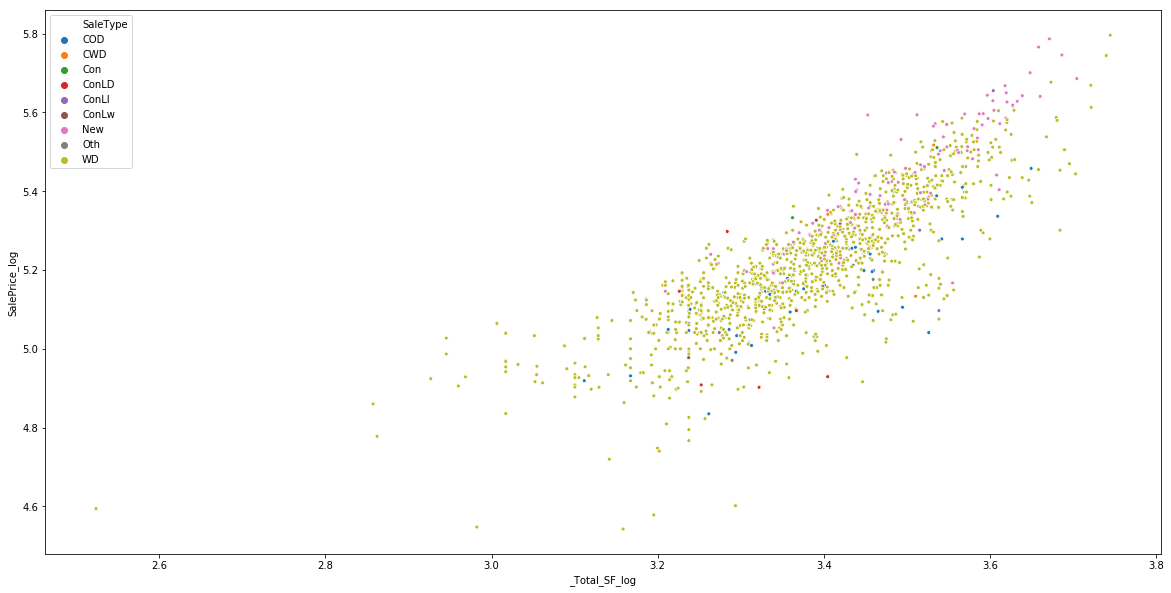

In [370]:
sns.scatterplot(data=house,x="_Total_SF_log",y="SalePrice_log",hue="SaleType",s=15);

In [371]:
house.Neighborhood.value_counts()

NAmes      203
CollgCr    150
OldTown     98
Somerst     86
Edwards     84
Gilbert     79
NridgHt     77
NWAmes      69
Sawyer      63
SawyerW     58
BrkSide     51
Crawfor     47
Mitchel     46
NoRidge     38
Timber      36
IDOTRR      35
StoneBr     23
SWISU       22
ClearCr     21
Blmngtn     17
MeadowV     16
BrDale      14
Veenker     11
NPkVill      9
Blueste      2
Name: Neighborhood, dtype: int64


# Neighbourhoods

Let's create dummy variable for the neighbourhood, using the neighbourhood **NAmes** as the reference, as it is the place where there is the most sales.

In [372]:
#house = pd.concat([house,pd.get_dummies(house['SaleCondition'], prefix = 'SaleCondition',drop_first=True)], axis=1)
house = pd.concat([house,pd.get_dummies(house['Neighborhood'], prefix = 'Neighborhood')], axis=1)
house = house.drop("Neighborhood_NAmes",axis=1)

In [373]:
house.columns[50:]

Index(['HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC',
       'Fence', 'MiscFeature', 'MiscVal', 'MoSold', 'YrSold', 'SaleType',
       'SaleCondition', 'SalePrice', 'SalePrice_log', '_Total_SF',
       '_Total_SF_log', 'GrLivArea_log', 'residual', 'per_SF',
       'Neighborhood_Blmngtn', 'Neighborhood_Blueste', 'Neighborhood_BrDale',
       'Neighborhood_BrkSide', 'Neighborhood_ClearCr', 'Neighborhood_CollgCr',
       'Neighborhood_Crawfor', 'Neighborhood_Edwards', 'Neighborhood_Gilbert',
       'Neighborhood_IDOTRR', 'Neighborhood_MeadowV', 'Neighborhood_Mitchel',
       'Neighborhood_NPkVill', 'Neighborhood_NWAmes', 'Neighborhood_NoRidge',
       'Neighborhood_NridgHt', 'Neighbor

In [374]:
neigh = {'Neighborhood_Blmngtn', 'Neighborhood_Blueste', 'Neighborhood_BrDale',
       'Neighborhood_BrkSide', 'Neighborhood_ClearCr', 'Neighborhood_CollgCr',
       'Neighborhood_Crawfor', 'Neighborhood_Edwards', 'Neighborhood_Gilbert',
       'Neighborhood_IDOTRR', 'Neighborhood_MeadowV', 'Neighborhood_Mitchel',
       'Neighborhood_NPkVill', 'Neighborhood_NWAmes', 'Neighborhood_NoRidge',
       'Neighborhood_NridgHt', 'Neighborhood_OldTown', 'Neighborhood_SWISU',
       'Neighborhood_Sawyer', 'Neighborhood_SawyerW', 'Neighborhood_Somerst',
       'Neighborhood_StoneBr', 'Neighborhood_Timber', 'Neighborhood_Veenker'}

In [375]:
linear_regression_neigh = smf.ols(formula='SalePrice_log ~ _Total_SF_log + '+" + ".join(neigh), data=house)
fitted_model_neigh = linear_regression_neigh.fit()
fitted_model_neigh.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          SalePrice_log   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     230.9
Date:                Fri, 23 Nov 2018   Prob (F-statistic):               0.00
Time:                        15:30:26   Log-Likelihood:                 1606.5
No. Observations:                1355   AIC:                            -3161.
Df Residuals:                    1329   BIC:                            -3025.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                2.4939      0.065     38.552      0.000       2.367       2.621
_Total_SF_log            0.7953      0.019     41.292      0.000       0.758       0.833
Neighborhood_Blmngtn     0.0567      0.019      2.997      0.003       0.020       0.094
Neighborhood_NPkVill     0.0044      0.025      0.173      0.863      -0.045       0.054
Neighborhood_Sawyer     -0.0083      0.011     -0.767      0.443      -0.029       0.013
Neighborhood_NridgHt     0.1723      0.011     16.180      0.000       0.151       0.193
Neighborhood_Crawfor     0.0779      0.012      6.395      0.000       0.054       0.102
Neighborhood_NoRidge     0.1466      0.014     10.555      0.000       0.119       0.174
Neighborhood_StoneBr     0.1713      0.017     10.236      0.000       0.139       0.204
Neighborhood_BrkSide    -0.0075      0.012     -0.634      0.526      -0.031       0.016
Neighborhood_Timber      0.1112      0.014      8.085      0.000       0.084       0.138
Neighborhood_NWAmes      0.0301      0.011      2.842      0.005       0.009       0.051
Neighborhood_Somerst     0.1210      0.010     12.440      0.000       0.102       0.140
Neighborhood_SawyerW     0.0483      0.011      4.328      0.000       0.026       0.070
Neighborhood_Edwards    -0.0271      0.010     -2.786      0.005      -0.046      -0.008
Neighborhood_MeadowV    -0.0640      0.020     -3.265      0.001      -0.102      -0.026
Neighborhood_BrDale     -0.0498      0.021     -2.398      0.017      -0.091      -0.009
Neighborhood_CollgCr     0.0777      0.008      9.564      0.000       0.062       0.094
Neighborhood_OldTown    -0.0618      0.009     -6.724      0.000      -0.080      -0.044
Neighborhood_Gilbert     0.0865      0.010      8.706      0.000       0.067       0.106
Neighborhood_Mitchel     0.0143      0.012      1.176      0.240      -0.010       0.038
Neighborhood_Veenker     0.1221      0.023      5.262      0.000       0.077       0.168
Neighborhood_SWISU      -0.0494      0.017     -2.943      0.003      -0.082      -0.016
Neighborhood_IDOTRR     -0.1138      0.014     -8.284      0.000      -0.141      -0.087
Neighborhood_Blueste     0.0142      0.053      0.268      0.789      -0.090       0.118
Neighborhood_ClearCr     0.0755      0.017      4.366      0.000       0.042       0.109
==============================================================================
Omnibus:                      148.246   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              458.887
Skew:                          -0.545   Prob(JB):                    2.26e-100
Kurtosis:                       5.634   Cond. No.                         119.
==============================================================================

Warnings:
[1] Standard Erro

In [376]:
not_relevant = {'Neighborhood_Blueste','Neighborhood_BrkSide','Neighborhood_Mitchel'
                ,'Neighborhood_Sawyer','Neighborhood_NPkVill'}

In [377]:
linear_regression_neigh = smf.ols(formula='SalePrice_log ~ _Total_SF_log + '+" + ".join(neigh-not_relevant), data=house)
fitted_model_neigh = linear_regression_neigh.fit()
fitted_model_neigh.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          SalePrice_log   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.810
Method:                 Least Squares   F-statistic:                     288.9
Date:                Fri, 23 Nov 2018   Prob (F-statistic):               0.00
Time:                        15:30:28   Log-Likelihood:                 1604.9
No. Observations:                1355   AIC:                            -3168.
Df Residuals:                    1334   BIC:                            -3058.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                2.4819      0.064     38.985      0.000       2.357       2.607
_Total_SF_log            0.7987      0.019     41.900      0.000       0.761       0.836
Neighborhood_Blmngtn     0.0568      0.019      3.054      0.002       0.020       0.093
Neighborhood_SawyerW     0.0486      0.011      4.578      0.000       0.028       0.069
Neighborhood_Edwards    -0.0265      0.009     -2.938      0.003      -0.044      -0.009
Neighborhood_MeadowV    -0.0631      0.019     -3.280      0.001      -0.101      -0.025
Neighborhood_BrDale     -0.0490      0.020     -2.397      0.017      -0.089      -0.009
Neighborhood_CollgCr     0.0779      0.007     10.598      0.000       0.063       0.092
Neighborhood_OldTown    -0.0613      0.008     -7.242      0.000      -0.078      -0.045
Neighborhood_NridgHt     0.1721      0.010     16.997      0.000       0.152       0.192
Neighborhood_Crawfor     0.0781      0.012      6.678      0.000       0.055       0.101
Neighborhood_Gilbert     0.0868      0.009      9.325      0.000       0.069       0.105
Neighborhood_NoRidge     0.1463      0.013     10.836      0.000       0.120       0.173
Neighborhood_StoneBr     0.1712      0.016     10.440      0.000       0.139       0.203
Neighborhood_Timber      0.1112      0.013      8.337      0.000       0.085       0.137
Neighborhood_NWAmes      0.0302      0.010      3.008      0.003       0.010       0.050
Neighborhood_Veenker     0.1221      0.023      5.325      0.000       0.077       0.167
Neighborhood_SWISU      -0.0491      0.016     -2.994      0.003      -0.081      -0.017
Neighborhood_Somerst     0.1211      0.009     13.315      0.000       0.103       0.139
Neighborhood_IDOTRR     -0.1132      0.013     -8.547      0.000      -0.139      -0.087
Neighborhood_ClearCr     0.0755      0.017      4.452      0.000       0.042       0.109
==============================================================================
Omnibus:                      147.118   Durbin-Watson:                   1.956
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              450.885
Skew:                          -0.544   Prob(JB):                     1.23e-98
Kurtosis:                       5.608   Cond. No.                         117.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [378]:
10**0.1721

1.4862778310073352

# How does it look

There are a couple of Neighbourhoods that do not have a significant Sale price difference with **NAmes**.

Looking at the neighbourhood with the highest sale price difference : Neighborhood_NridgHt	0.1721	

That represents a 50% increase on the final Sale Price.

But it is due to the neighbourhood only of to another variable, like **OverallQual**.

Let's test it.

In [379]:
linear_regression_neigh = smf.ols(formula='SalePrice_log ~ _Total_SF_log +OverallQual+ '+" + ".join(neigh-not_relevant), data=house)
fitted_model_neigh = linear_regression_neigh.fit()
fitted_model_neigh.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          SalePrice_log   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     374.2
Date:                Fri, 23 Nov 2018   Prob (F-statistic):               0.00
Time:                        15:31:02   Log-Likelihood:                 1779.2
No. Observations:                1355   AIC:                            -3514.
Df Residuals:                    1333   BIC:                            -3400.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                2.9344      0.060     48.506      0.000       2.816       3.053
_Total_SF_log            0.5917      0.020     29.933      0.000       0.553       0.630
OverallQual              0.0445      0.002     19.774      0.000       0.040       0.049
Neighborhood_Blmngtn    -0.0035      0.017     -0.211      0.833      -0.036       0.029
Neighborhood_SawyerW     0.0197      0.009      2.088      0.037       0.001       0.038
Neighborhood_Edwards    -0.0189      0.008     -2.375      0.018      -0.034      -0.003
Neighborhood_MeadowV    -0.0490      0.017     -2.892      0.004      -0.082      -0.016
Neighborhood_BrDale     -0.0928      0.018     -5.125      0.000      -0.128      -0.057
Neighborhood_CollgCr     0.0353      0.007      5.186      0.000       0.022       0.049
Neighborhood_OldTown    -0.0652      0.007     -8.754      0.000      -0.080      -0.051
Neighborhood_NridgHt     0.0842      0.010      8.466      0.000       0.065       0.104
Neighborhood_Crawfor     0.0560      0.010      5.418      0.000       0.036       0.076
Neighborhood_Gilbert     0.0447      0.008      5.289      0.000       0.028       0.061
Neighborhood_NoRidge     0.0854      0.012      6.959      0.000       0.061       0.109
Neighborhood_StoneBr     0.0803      0.015      5.308      0.000       0.051       0.110
Neighborhood_Timber      0.0572      0.012      4.753      0.000       0.034       0.081
Neighborhood_NWAmes      0.0094      0.009      1.053      0.293      -0.008       0.027
Neighborhood_Veenker     0.0845      0.020      4.172      0.000       0.045       0.124
Neighborhood_SWISU      -0.0425      0.014     -2.944      0.003      -0.071      -0.014
Neighborhood_Somerst     0.0513      0.009      5.860      0.000       0.034       0.068
Neighborhood_IDOTRR     -0.1009      0.012     -8.648      0.000      -0.124      -0.078
Neighborhood_ClearCr     0.0649      0.015      4.352      0.000       0.036       0.094
==============================================================================
Omnibus:                      205.313   Durbin-Watson:                   1.928
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              653.085
Skew:                          -0.749   Prob(JB):                    1.53e-142
Kurtosis:                       6.054   Cond. No.                         258.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Taking into account OverallQual, we notice that the most expensive neighbourhood is notlonger the same.

We can interpret this by the fact that the properties are more expensive in **NridgHt** also because the properties there have a higher OverallQual.

Let's just redo the regression, but without the NridgHt, to see the potential influence of the correlation : about 0.2 %.


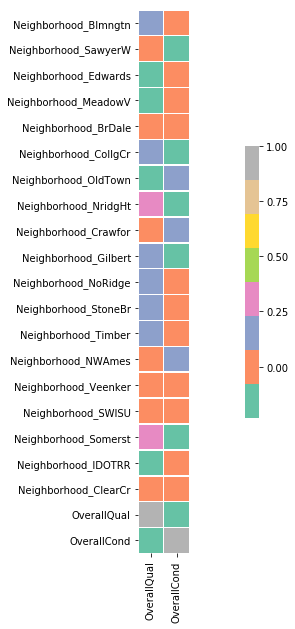

In [383]:
corr = house[list(neigh-not_relevant)+['OverallQual','OverallCond']].corr(method="spearman")
sns.heatmap(corr[['OverallQual','OverallCond']],cmap=cmap,square=True, linewidths=.5, cbar_kws={"shrink": .5})



In [381]:
house_no_Neighborhood_NridgHt = house[house.Neighborhood_NridgHt==False]

linear_regression_neigh = smf.ols(formula='SalePrice_log ~ _Total_SF_log +OverallQual+ '+" + ".join(neigh-not_relevant)
                                  , data=house_no_Neighborhood_NridgHt)
fitted_model_neigh = linear_regression_neigh.fit()
fitted_model_neigh.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          SalePrice_log   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     321.5
Date:                Fri, 23 Nov 2018   Prob (F-statistic):               0.00
Time:                        15:31:19   Log-Likelihood:                 1680.0
No. Observations:                1278   AIC:                            -3318.
Df Residuals:                    1257   BIC:                            -3210.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                2.9723      0.061     48.665      0.000       2.852       3.092
_Total_SF_log            0.5820      0.020     29.183      0.000       0.543       0.621
OverallQual              0.0435      0.002     18.844      0.000       0.039       0.048
Neighborhood_Blmngtn    -0.0006      0.017     -0.036      0.971      -0.033       0.032
Neighborhood_SawyerW     0.0214      0.009      2.262      0.024       0.003       0.040
Neighborhood_Edwards    -0.0195      0.008     -2.460      0.014      -0.035      -0.004
Neighborhood_MeadowV    -0.0513      0.017     -3.032      0.002      -0.084      -0.018
Neighborhood_BrDale     -0.0934      0.018     -5.166      0.000      -0.129      -0.058
Neighborhood_CollgCr     0.0374      0.007      5.473      0.000       0.024       0.051
Neighborhood_OldTown    -0.0652      0.007     -8.764      0.000      -0.080      -0.051
Neighborhood_NridgHt -4.912e-17   1.08e-17     -4.540      0.000   -7.04e-17   -2.79e-17
Neighborhood_Crawfor     0.0580      0.010      5.604      0.000       0.038       0.078
Neighborhood_Gilbert     0.0466      0.008      5.499      0.000       0.030       0.063
Neighborhood_NoRidge     0.0902      0.012      7.328      0.000       0.066       0.114
Neighborhood_StoneBr     0.0851      0.015      5.603      0.000       0.055       0.115
Neighborhood_Timber      0.0607      0.012      5.030      0.000       0.037       0.084
Neighborhood_NWAmes      0.0115      0.009      1.298      0.194      -0.006       0.029
Neighborhood_Veenker     0.0871      0.020      4.302      0.000       0.047       0.127
Neighborhood_SWISU      -0.0418      0.014     -2.900      0.004      -0.070      -0.014
Neighborhood_Somerst     0.0542      0.009      6.167      0.000       0.037       0.071
Neighborhood_IDOTRR     -0.1020      0.012     -8.758      0.000      -0.125      -0.079
Neighborhood_ClearCr     0.0673      0.015      4.512      0.000       0.038       0.097
==============================================================================
Omnibus:                      216.576   Durbin-Watson:                   1.954
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              715.856
Skew:                          -0.822   Prob(JB):                    3.58e-156
Kurtosis:                       6.277   Cond. No.                     1.08e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.51e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [382]:
(10**0.0445-10**0.0435)/10**0.0445*100

0.22999361774467464

In [462]:
base = " + ".join(["_Total_SF_log","OverallQual","OverallCond","GarageCars","isNew","Total_Bath"])
linear_regression_neigh = smf.ols(formula='SalePrice_log ~ '+ base + "+" + " + ".join(neigh-not_relevant)
                                  , data=house)
fitted_model_neigh = linear_regression_neigh.fit()
fitted_model_neigh.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          SalePrice_log   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.892
Method:                 Least Squares   F-statistic:                     448.7
Date:                Fri, 23 Nov 2018   Prob (F-statistic):               0.00
Time:                        16:28:16   Log-Likelihood:                 1992.1
No. Observations:                1355   AIC:                            -3932.
Df Residuals:                    1329   BIC:                            -3797.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                3.0867      0.057     54.029      0.000       2.975       3.199
isNew[T.True]            0.0379      0.006      6.168      0.000       0.026       0.050
_Total_SF_log            0.4942      0.018     26.794      0.000       0.458       0.530
OverallQual              0.0344      0.002     17.296      0.000       0.030       0.038
OverallCond              0.0209      0.002     13.133      0.000       0.018       0.024
GarageCars               0.0323      0.003     11.263      0.000       0.027       0.038
Total_Bath               0.0278      0.002     11.777      0.000       0.023       0.032
Neighborhood_Blmngtn    -0.0030      0.014     -0.210      0.834      -0.031       0.025
Neighborhood_SawyerW     0.0141      0.008      1.703      0.089      -0.002       0.030
Neighborhood_Edwards    -0.0102      0.007     -1.483      0.138      -0.024       0.003
Neighborhood_MeadowV    -0.0465      0.015     -3.186      0.001      -0.075      -0.018
Neighborhood_BrDale     -0.0838      0.016     -5.352      0.000      -0.114      -0.053
Neighborhood_CollgCr     0.0302      0.006      5.006      0.000       0.018       0.042
Neighborhood_OldTown    -0.0651      0.007     -9.992      0.000      -0.078      -0.052
Neighborhood_NridgHt     0.0709      0.009      7.864      0.000       0.053       0.089
Neighborhood_Crawfor     0.0461      0.009      5.153      0.000       0.029       0.064
Neighborhood_Gilbert     0.0252      0.008      3.295      0.001       0.010       0.040
Neighborhood_NoRidge     0.0668      0.011      6.193      0.000       0.046       0.088
Neighborhood_StoneBr     0.0760      0.013      5.753      0.000       0.050       0.102
Neighborhood_Timber      0.0431      0.011      4.097      0.000       0.022       0.064
Neighborhood_NWAmes     -0.0136      0.008     -1.756      0.079      -0.029       0.002
Neighborhood_Veenker     0.0525      0.017      3.013      0.003       0.018       0.087
Neighborhood_SWISU      -0.0292      0.013     -2.333      0.020      -0.054      -0.005
Neighborhood_Somerst     0.0349      0.008      4.350      0.000       0.019       0.051
Neighborhood_IDOTRR     -0.0745      0.010     -7.393      0.000      -0.094      -0.055
Neighborhood_ClearCr     0.0542      0.013      4.231      0.000       0.029       0.079
==============================================================================
Omnibus:                      229.695   Durbin-Watson:                   1.952
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              881.089
Skew:                          -0.778   Prob(JB):                    4.72e-192
Kurtosis:                       6.631   Cond. No.                         378.
==============================================================================

Warnings:
[1] Standard Erro

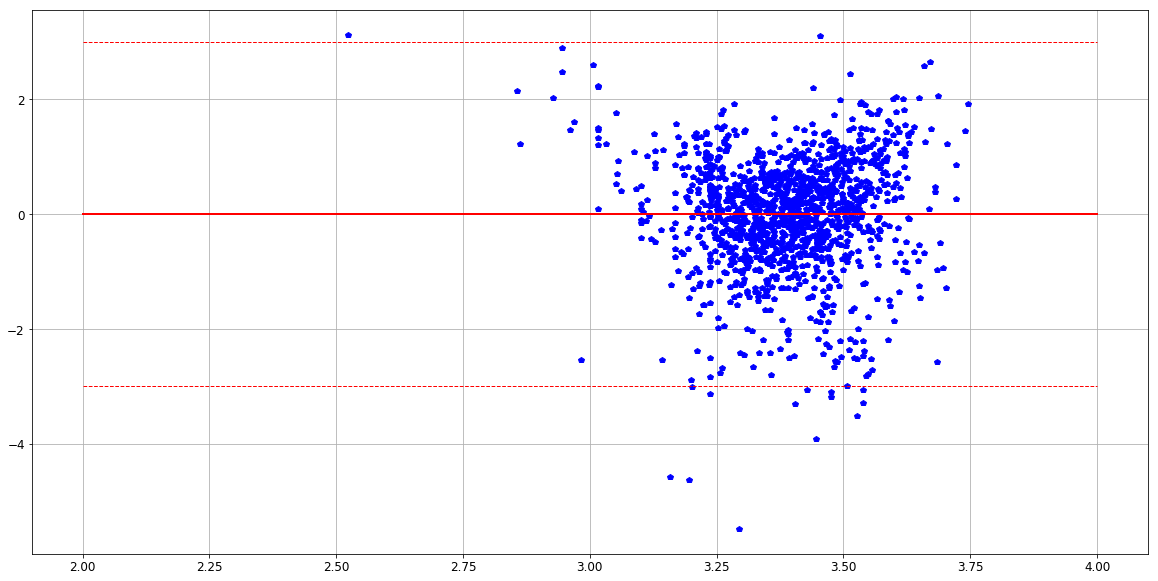

In [463]:
in_the_regression = ["_Total_SF_log","OverallQual"]+list(neigh-not_relevant)

betas = np.array(fitted_model.params)
fitted_values = fitted_model.predict(house[in_the_regression])
residuals = house.SalePrice_log-fitted_values
normalized_residuals = standardize(residuals)
residual_scatter_plot = plt.plot(house._Total_SF_log, normalized_residuals,'bp')
x_range = [house._Total_SF_log.min(),house._Total_SF_log.max()]
mean_residual = plt.plot([int(x_range[0]),round(x_range[1],0)], [0,0], '-', color='red', linewidth=2)
upper_bound = plt.plot([int(x_range[0]),round(x_range[1],0)], [3,3], '--', color='red', linewidth=1)
lower_bound = plt.plot([int(x_range[0]),round(x_range[1],0)], [-3,-3], '--', color='red', linewidth=1)
plt.grid()

In [464]:
house[normalized_residuals<-2.5][house.columns[:30]]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation
30,31,70,C (all),50.000,8500,Pave,Pave,Reg,Lvl,AllPub,...,1950,Gambrel,CompShg,BrkFace,BrkFace,None,0.000,TA,Fa,BrkTil
78,79,90,RL,72.000,10778,Pave,NaN,Reg,Lvl,AllPub,...,1968,Hip,CompShg,HdBoard,HdBoard,None,0.000,TA,TA,CBlock
88,89,50,C (all),105.000,8470,Pave,NaN,IR1,Lvl,AllPub,...,1982,Hip,CompShg,Plywood,Plywood,None,0.000,Fa,Fa,CBlock
93,94,190,C (all),60.000,7200,Pave,NaN,Reg,Lvl,AllPub,...,1998,Hip,CompShg,MetalSd,MetalSd,None,0.000,TA,TA,BrkTil
144,145,90,RM,70.000,9100,Pave,NaN,Reg,Lvl,AllPub,...,1963,Gable,CompShg,HdBoard,HdBoard,BrkFace,336.000,TA,TA,CBlock
198,199,75,RM,92.000,5520,Pave,NaN,Reg,Lvl,AllPub,...,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.000,TA,TA,CBlock
330,331,90,RL,nan,10624,Pave,NaN,IR1,Lvl,AllPub,...,1964,Gable,CompShg,HdBoard,HdBoard,BrkFace,84.000,TA,TA,CBlock
431,432,50,RM,60.000,5586,Pave,NaN,IR1,Bnk,AllPub,...,1998,Gable,CompShg,MetalSd,MetalSd,None,0.000,TA,TA,BrkTil
462,463,20,RL,60.000,8281,Pave,NaN,IR1,Lvl,AllPub,...,1965,Gable,CompShg,MetalSd,MetalSd,None,0.000,TA,TA,CBlock
495,496,30,C (all),60.000,7879,Pave,NaN,Reg,Lvl,AllPub,...,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.000,TA,TA,CBlock


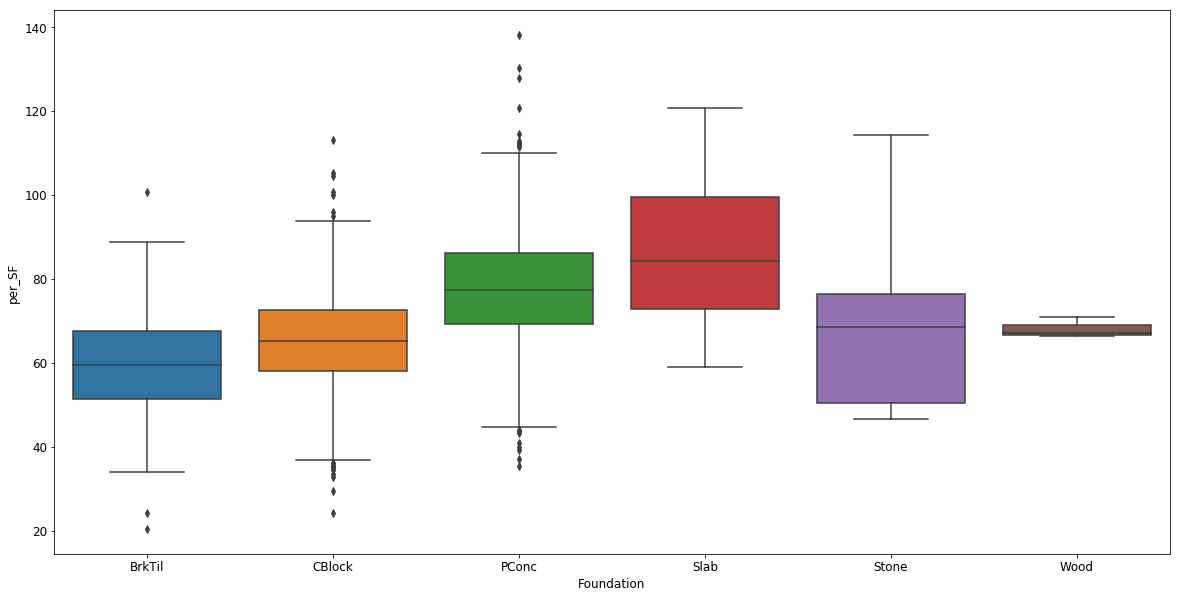

In [453]:
sns.boxplot(data=house,y="per_SF",x="Foundation")

In [ ]:
house["Total_Bath"] = sum(house[c] for c in house.columns if "ath" in c)
baths = [c for c in house.columns if "ath" in c]
house.Total_Bath = house.Total_Bath.apply(lambda x: x if x < 5 else 4)



In [454]:
house["isNew"]= (house.SaleType=="New")
house["isCBlock"]= (house.Foundation=="isCBlock")


In [460]:
regr = linear_model.LinearRegression()
other_for_reg = list(house[other].select_dtypes(include='int64').columns) + ["isNew","isCBlock"]


for_reg = house[list(neigh-not_relevant)+["_Total_SF_log","SalePrice_log"]+other_for_reg].fillna(0)
y = for_reg[["SalePrice_log"]]

base_set = set(["_Total_SF_log","OverallQual","OverallCond","GarageCars","isNew","Total_Bath"])
select_from = list(set(other_for_reg)-base_set)
for col in select_from:
    x = for_reg[list(base_set)+list(neigh-not_relevant)+[col]]
    cross_valid = cross_val_score(regr, x, y, cv=5)
    print(col,np.average(cross_valid),"%.2f"%(np.std(cross_valid)*100))

BedroomAbvGr 0.8899499395361831 0.79
TotRmsAbvGrd 0.8891121570715843 0.81
WoodDeckSF 0.8913357359100746 0.88
BsmtHalfBath 0.8897747394110163 0.78
3SsnPorch 0.8892763402394351 0.84
HalfBath 0.8895050181964429 0.81
BsmtFullBath 0.8900576070033441 0.78
isCBlock 0.889422971935281 0.82
BsmtFinSF1 0.893407751242688 0.86
LowQualFinSF 0.8890444093606001 0.82
OpenPorchSF 0.8894875161165597 0.78
PoolArea 0.8890051642125298 0.82
MiscVal 0.8892794880532021 0.81
MSSubClass 0.8906964525219871 0.80
EnclosedPorch 0.8889387707444694 0.89
ScreenPorch 0.8901268235412996 0.79
KitchenAbvGr 0.8911949165458248 0.80
Fireplaces 0.8923784432535798 0.82
FullBath 0.889197329143791 0.83


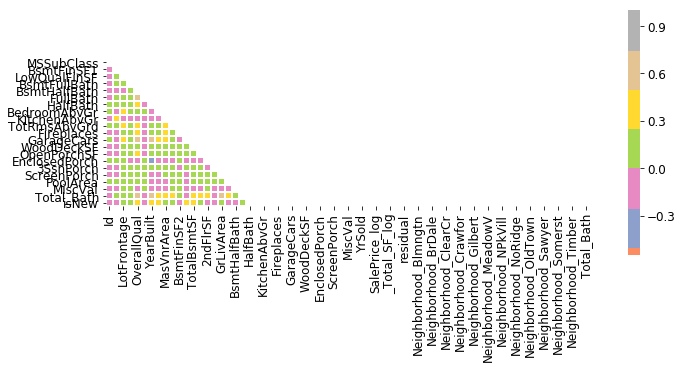

In [434]:
cmap = sns.mpl_palette("Set2", 8)
plt.rcParams.update({'font.size': 12})
def show_corr(df,select_from):
    corr = df.corr()
    mask = np.zeros_like(corr[corr.index.isin(select_from)], dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    f, ax = plt.subplots(figsize=(11, 9))
    sns.heatmap(corr[corr.index.isin(select_from)],  mask=mask,cmap=cmap, center=0,annot=False,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},fmt='.1f'
               );
show_corr(house,select_from)

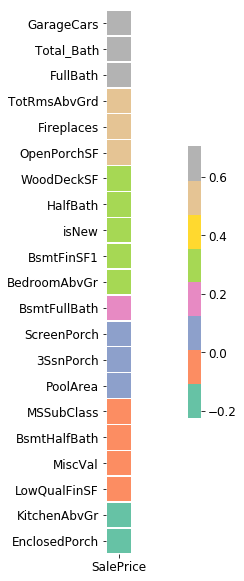

In [435]:
corr = house.corr(method="spearman")
sns.heatmap(corr[corr.index.isin(select_from)][["SalePrice"]].sort_values("SalePrice",ascending=False),cmap=cmap,square=True, linewidths=.5, cbar_kws={"shrink": .5})



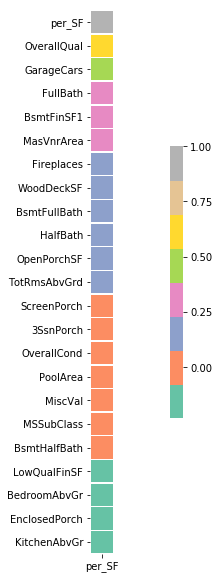

In [402]:
corr = house[other+["per_SF"]].corr()
sns.heatmap(corr[["per_SF"]].sort_values("per_SF",ascending=False),cmap=cmap,square=True, linewidths=.5, cbar_kws={"shrink": .5})



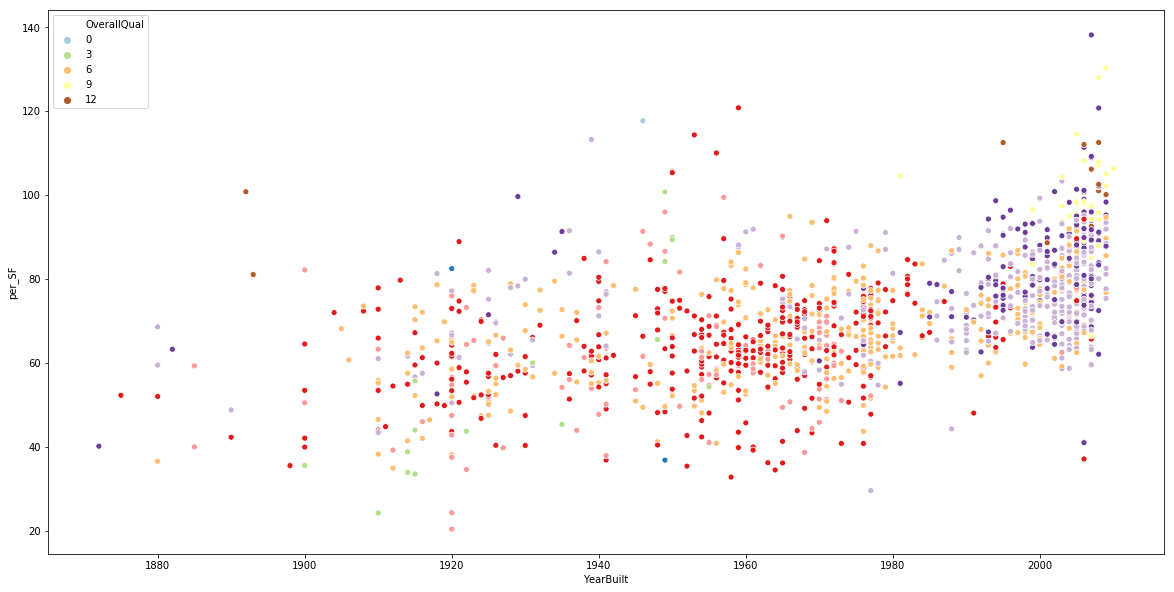

In [386]:
sns.scatterplot(data=house, x='YearBuilt',y='per_SF',hue="OverallQual",palette="Paired")

In [415]:
pd.crosstab(house.SaleType,house.OverallQual,margins=True)


OverallQual,1,2,3,4,5,6,7,8,9,10,All
SaleType,,,,,,,,,,,
COD,0,0,0,5,14,14,3,3,0,0,39
CWD,0,0,0,0,0,1,1,0,1,0,3
Con,0,0,0,0,0,0,1,1,0,0,2
ConLD,0,0,2,0,1,3,1,1,0,0,8
ConLI,0,0,0,1,1,2,0,0,0,1,5
ConLw,0,0,0,0,1,0,3,0,0,0,4
New,0,0,0,1,2,12,46,37,17,5,120
Oth,0,0,0,2,1,0,0,0,0,0,3
WD,1,2,14,95,327,323,254,122,25,8,1171


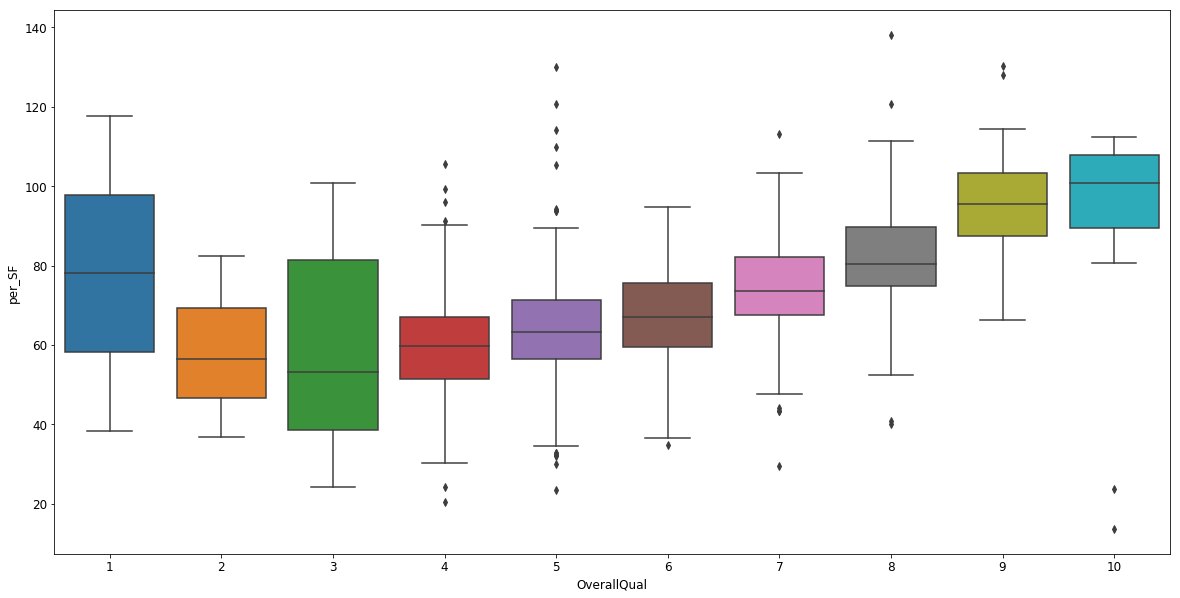

In [177]:
sns.boxplot(data=house, x="OverallQual",y="per_SF")

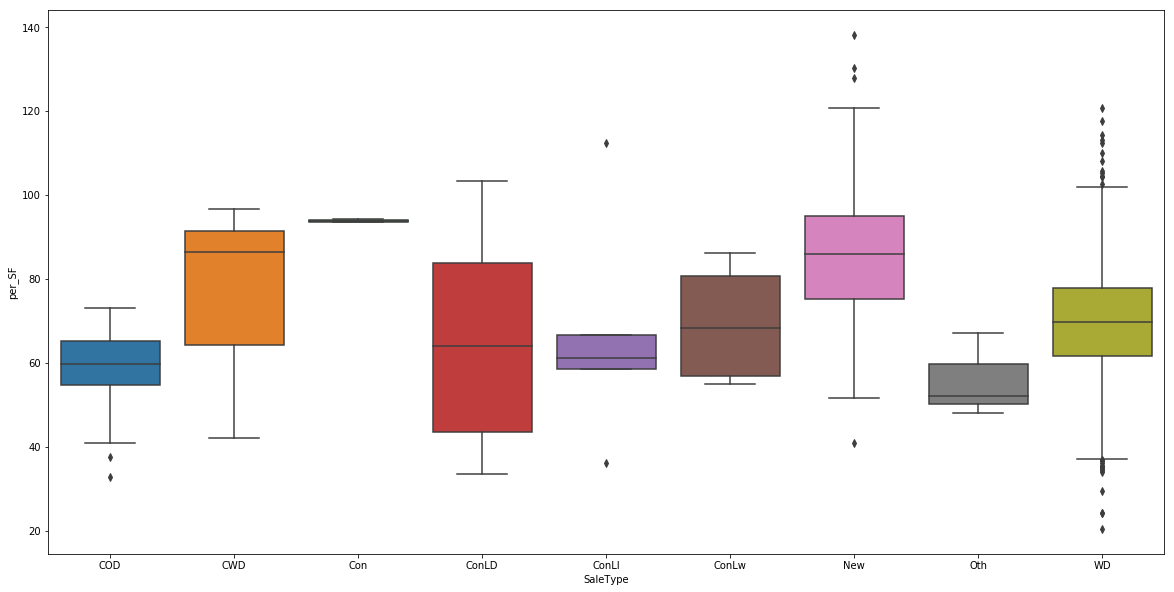

In [395]:
sns.boxplot(data=house,y="per_SF",x="SaleType")

In [399]:
house["Total_Bath"] = sum(house[c] for c in house.columns if "ath" in c)
baths = [c for c in house.columns if "ath" in c]
house.Total_Bath = house.Total_Bath.apply(lambda x: x if x < 5 else 4)

house[baths].sample(5)

,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,Total_Bath
1047,0,1,1,0,2
1289,0,0,2,1,3
11,1,0,3,0,4
246,0,0,2,0,2
1277,1,0,1,1,3


In [407]:
house.Total_Bath.value_counts()

2    529
3    447
1    207
4    166
6      3
5      3
Name: Total_Bath, dtype: int64

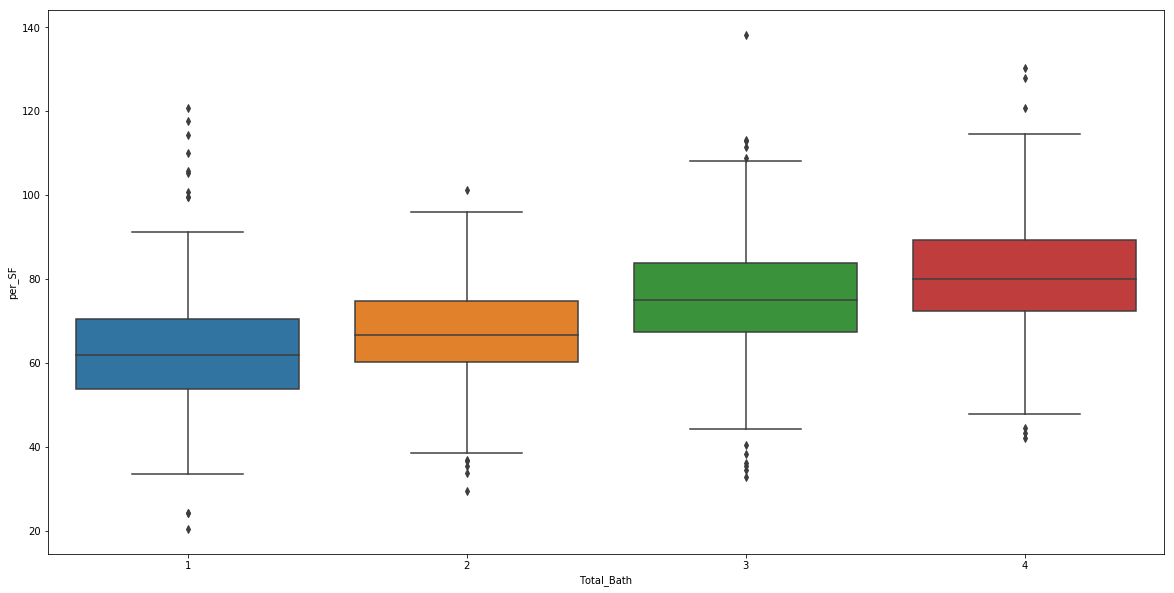

In [411]:
sns.boxplot(data=house,y="per_SF",x="Total_Bath")

In [ ]:
stats